# Prova 3

Instructions:
- Exercises are grouped by topic and ordered by increasing difficulty within each topic.
- Submit your solutions in a well-organized Jupyter notebook.
- You are responsible for creating robust test cases for each question. Ensure your tests cover all possible cases, especially edge cases (e.g., with the largest possible N ).
- Verify that all your solutions meet the specified time constraints. Unless otherwise stated, each question has a 1-second time limit. Some of the later questions may have different limits, which will be indicated.
- Be sure that the inputs (which will be created by you) match the specifications, and your solutions meets the required time limit.
- Presentation matters: make sure your notebook is clean, well-structured, and that both solutions and test cases are clearly labeled.

In [170]:
# from qiskit import QuantumCircuit, Aer, execute
from qiskit.circuit.library import (
    HGate, 
    ZGate, 
    XGate, 
    YGate,
    IGate,
)
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.primitives import StatevectorSampler
from qiskit.visualization import (
    plot_bloch_multivector,
    array_to_latex, 
    plot_histogram,
)
from sympy.parsing.sympy_parser import parse_expr
from sympy.logic.inference import satisfiable


import numpy as np
from numpy.random import default_rng, shuffle

rng = default_rng()

## Distinguishing Unitaries and States

**Exercise 1.** You are given an operation that implements a single-qubit unitary transformation: either the H gate or the X gate. The operation will have Adjoint and Controlled variants defined. Your task is to perform necessary operations and measurements to figure out which unitary it was and to return 0 if it was the H gate or 1 if it was the X gate. You are allowed to apply the given operation and its adjoint/controlled variants at most twice. You have to implement an operation which takes a single-qubit operation as an input and returns an integer.

In [243]:
# 0 -> Gate H, 1 -> Gate X 
def solve1(operator) -> int:
    # We'll apply UXU|0> and measure.
    # When U=X -> XXX|0> = X|0> = |1>
    # When U=H -> HXH|0> = HX(|0>+|1>) = H(|0>+|1>) = |0>
    
    qc = QuantumCircuit(1, 1)           # 1 quibit + 1 bit (output measure)
    qc.append(operator, [0])
    qc.x(0)
    qc.append(operator, [0])
    
    qc.measure(0, 0)
    # qc.draw('mpl') # plot the circuit
    
    sampler = StatevectorSampler()
    job = sampler.run([qc], shots=1)
    result = job.result()[0].data['c'].get_counts() # A map with the measured val

    return int([k for k in result.keys()][0])
    

In [244]:
# Testing 

tests = [i%2 for i in range(20)]
shuffle(tests)
result_test = {'Accepted':0, 'Wrong Answer':0}
tests_inputs = {'X':0, 'H':0}
for tt in tests:
    gate = XGate() if tt == 1 else HGate()
    tests_inputs[('X' if tt == 1 else 'H')] += 1
    expected = tt
    res = solve1(gate)
    if res == expected: 
        result_test['Accepted'] += 1
    else: 
        result_test['Wrong Answer'] += 1
    
### Showing results
print("The case tests:", tests_inputs)
print(result_test)

The case tests: {'X': 10, 'H': 10}
{'Accepted': 20, 'Wrong Answer': 0}


**Exercise 2.** You are given an operation that implements a single-qubit unitary transformation: either the identity (I gate) or one of the Pauli gates (X, Y or Z gate). The operation will have Adjoint and Controlled variants defined. Your task is to perform necessary operations and measurements to figure out which unitary it was and to return

- 0 if it was the I gate,
- 1 if it was the X gate,
- 2 if it was the Y gate,
- 3 if it was the Z gate.

You are allowed to apply the given operation and its adjoint/controlled variants exactly once. You have to implement an operation which takes a single-qubit operation as an input and returns an integer.

In [278]:
# 0 -> Gate I, 1 -> Gate X, 2 -> Gate Y, 3 -> Gate Z 
def solve2(U_gate) -> int:
    # In: 1-qubit Operator 
    # We'll use the Bell States, from the |\Phi_+> we'll apply the Gate U
    # And know where the States will be, in some Bell state so get them back by a measurement
    
    # Preparing |\Phi_+>
    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.cx(control_qubit=0, target_qubit=1)

    # Appy the U x I
    qc.append(U_gate, [0])

    # Measure in the Bell states -> Back into {|00>, |01>, |10>, |11>}
    # 00 -> I, 10 -> X, 01 -> Z, 11 -> Y
    qc.cx(control_qubit=0, target_qubit=1)
    qc.h(0)

    qc.measure([0,1],[0,1])

    # qc.draw('mpl') # Plot the circuit

    sampler = StatevectorSampler()
    job = sampler.run([qc], shots=1)
    result = job.result()[0].data['c'].get_counts() # A map with the measured val
    
    result = [el for el in result.keys()][0]
    mp = {'00': 0, '10' : 1, '01' : 3, '11' : 2}
    return mp[result]

res = solve2(ZGate())
res

3

In [281]:
# Testing 
tests = [i%4 for i in range(200)]
shuffle(tests)
result_test = {'Accepted':0, 'Wrong Answer':0}
tests_inputs = {'I':0, 'X':0, 'Y':0, 'Z':0}
inmap = {0: 'I', 1:'X', 2:'Y', 3:'Z'}
gatemap = {0: IGate(), 1:XGate(), 2:YGate(), 3:ZGate()}

for tt in tests:
    gate = gatemap[tt]
    tests_inputs[inmap[tt]] += 1
    expected = tt
    
    res = solve2(gate)
    if res == expected: 
        result_test['Accepted'] += 1
    else: 
        result_test['Wrong Answer'] += 1
    
### Showing results
print("The case tests:", tests_inputs)
print(result_test)

The case tests: {'I': 50, 'X': 50, 'Y': 50, 'Z': 50}
{'Accepted': 200, 'Wrong Answer': 0}


**Exercise 3.** You are given 3 qubits which are guaranteed to be in one of the two states:
|ψ0⟩ = 1
√3(|100⟩ + ω|010⟩ + ω2|001⟩)
|ψ1⟩ = 1
√3(|100⟩ + ω2|010⟩ + ω|001⟩)
where ω = e2iπ/3.
Your task is to perform necessary operations and measurements to figure out which state
it was and to return 0 if it was |psi0⟩ state or 1 if it was |ψ1⟩ state. The state of the qubits
after the operations does not matter.
You have to implement an operation which takes an array of 3 qubits as an input and
returns an integer.

**Exercise 4.** You are given two qubits in state |00⟩. Your task is to create the following
state on them: (|00⟩ + |01⟩ + |10⟩)/√3.
You have to implement an operation which takes an array of 2 qubits as an input and
has no output. The ”output” of your solution is the state in which it left the input qubits.

Statevector([0.57735027+0.j, 0.57735027+0.j, 0.57735027+0.j,
             0.        +0.j],
            dims=(2, 2))


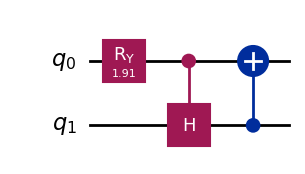

In [283]:
from math import acos, sqrt

def solve4():
    # As done in Assignment 3, question 3.
    # R_y(k) = cos(k/2)|0> + sin(k/2)|1> 
    # with k = 2 arccos(1/\sqrt(3)), R_y |0> = \sqrt(1/3)|0> + \sqrt(2/3)|1> 
    # 1- So, R_y(k)|00> =  \sqrt(1/3)|00> + \sqrt(2/3)|10>
    # 2- Apply ctr-H (0 -> 1) => \sqrt(1/3)|00> + \sqrt(2/3)[\sqrt(1/2)(|10>+|11>)] = \sqrt(1/3)[|00> + |10> + |11>]
    # 3- Finally apply ctr-X (1 -> 0) => \sqrt(1/3)[|00> + |10> + |01>]
    
    angle = 2 * acos(1/sqrt(3))
    
    qc = QuantumCircuit(2,0)
    
    # 1.
    qc.ry(angle, [0])
    
    # 2. 
    qc.ch(control_qubit=0,target_qubit=1)
    
    # 3. 
    qc.cx(control_qubit=1, target_qubit=0)
    
    
    state = Statevector(qc)
    return qc, state
    
qc, _ = solve4()
qc.draw('mpl')
    

In [290]:
# Testing
_, state = solve4()
expected = Statevector([1/sqrt(3),1/sqrt(3),1/sqrt(3), 0])

result_test = {'Accepted':0, 'Wrong Answer':0}
result_test['Accepted' if state.equiv(expected) else 'Wrong Answer'] += 1
print(result_test)

{'Accepted': 1, 'Wrong Answer': 0}
